# Training SODA encoder

Code for training our implementation of [SODA](https://arxiv.org/abs/2311.17901) encoder on a variation of the [Deepmind's 3D-Shapes Dataset](https://github.com/google-deepmind/3d-shapes).

First, as the authors mention in the paper, the latent representation of the image is derived by a [ResNet](https://arxiv.org/pdf/1512.03385) encoder (Hudson, et al., 2023). in this case we are going to train a **ResNet18 to predict the latent representations of the images dataset**. Our implementation of ResNet is based in the [Pytorch Resnet Module Source Code](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). So we are not using any of the pretrained ResNet models from PuTorch.

## Load Data

To start the training of the network we first load the data from the H5 files.

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
import utils
from models.soda_encoder import SodaEncoder
from models.pretrained_resnet18 import PretrainedResNet18Encoder

Define data directories.

In [2]:
data_directory: str = "data"
train_file_name: str = "3dshapes_abstraction_train.h5"
test_file_name: str = "3dshapes_abstraction_test.h5"

train_file_path: str = os.path.join(data_directory, train_file_name)
test_file_path: str = os.path.join(data_directory, test_file_name)

FACTORS_IN_ORDER: list[str] = [
    'floor_hue', 
    'wall_hue', 
    'object_hue', 
    'scale', 
    'shape',                 
    'orientation'
]
NUM_VALUES_PER_FACTOR: dict[str, int] = {
    'floor_hue': 10, 
    'wall_hue': 10, 
    'object_hue': 10,
    'scale': 8, 
    'shape': 4,
    'orientation': 15
}
MAX_VALUES_PER_FACTOR: dict[str, int] = {
    'floor_hue': 1, 
    'wall_hue': 1, 
    'object_hue': 1,
    'scale': 1, 
    'shape': 3,
    'orientation': 30
}
MIN_VALUES_PER_FACTOR: dict[str, int] = {
    'floor_hue': 0, 
    'wall_hue': 0, 
    'object_hue': 0,
    'scale': 0, 
    'shape': 0,
    'orientation': -30
}


Load dataset file contents from H5 files.

In [3]:
train_dataset: h5py.File = h5py.File(train_file_path, 'r')
test_dataset: h5py.File = h5py.File(test_file_path, 'r')

In [4]:
class ShapesDataset(torch.utils.data.Dataset):
    """
    Dataset class for handling image and label data.

    Args:
        images (np.ndarray): Array of images.
        labels (np.ndarray): Array of corresponding labels.
        sampling_rate (int, optional): Homogeneus sampling rate. Defaults to 1.
                                        If sampling rate is higher than 1, it will get 1 sample each sampling_rate samples.

    """
    def __init__(self, images, labels, sampling_rate=1):
        n_samples: int = len(images)

        # Create an array of indices for homogeneous sampling
        selected_indices = np.arange(0, n_samples, sampling_rate)

        # Apply sampling to images and labels
        self.images: np.ndarray = images[selected_indices]
        self.labels: np.ndarray = labels[selected_indices]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

Create the datasets for training and evaluation. Use a sampling rate of 1 every `sampling_rate` instances in the dataset due to hardware limitations.

In [5]:
sampling_rate: int = 25
train_dataset = ShapesDataset(train_dataset['images'], train_dataset['labels'], sampling_rate)
test_dataset = ShapesDataset(test_dataset['images'], test_dataset['labels'], sampling_rate)

Define relevant hyperparameters for training.

In [6]:
BATCH_SIZE: int = 256
EPOCHS: int = 30
LEARNING_RATE: float = 0.001
DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

Instantiate data loaders.

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

Define a training function.

In [8]:
def get_min_max_latents() -> tuple[torch.Tensor, torch.Tensor]:
    min_latents: torch.Tensor = torch.tensor([MIN_VALUES_PER_FACTOR[f] for f in FACTORS_IN_ORDER], dtype=torch.float32)
    max_latents: torch.Tensor = torch.tensor([MAX_VALUES_PER_FACTOR[f] for f in FACTORS_IN_ORDER], dtype=torch.float32)
    return min_latents, max_latents

In [9]:
def normalize_latents(latents: torch.Tensor, min_latents: torch.Tensor, max_latents: torch.Tensor) -> torch.Tensor:
    return (latents - min_latents) / (max_latents - min_latents)

def denormalize_latents(latents: torch.Tensor, min_latents: torch.Tensor, max_latents: torch.Tensor) -> torch.Tensor:
    return latents * (max_latents - min_latents) + min_latents

In [10]:
def calculate_loss(model, images, latents, criterion, min_latent, max_latent):
    images = images.permute(0, 3, 1, 2).to(DEVICE).float()
    latents = latents.to(DEVICE)

    latents_normalized = normalize_latents(latents, min_latent, max_latent) # Normaliza para la entrada de la red
    outputs = model(images)

    # Calcula la pérdida directamente con los latentes normalizados y las salidas
    ones: torch.Tensor = torch.ones(latents.shape[0]).to(DEVICE)
    loss: torch.Tensor = criterion(outputs, latents, ones)

    # Desnormaliza las salidas y los latentes originales para calcular el MAE
    denormalized_predicted_latents = denormalize_latents(outputs, min_latent, max_latent)
    denormalized_expected_latents = denormalize_latents(latents_normalized, min_latent, max_latent)

    mae = torch.abs(denormalized_expected_latents - denormalized_predicted_latents)

    return loss, mae


In [11]:
def get_latent_possible_values(factor: str) -> np.ndarray:
    return np.linspace(MIN_VALUES_PER_FACTOR[factor], MAX_VALUES_PER_FACTOR[factor], NUM_VALUES_PER_FACTOR[factor])

for factor in FACTORS_IN_ORDER:
    print(f"{factor}: {get_latent_possible_values(factor)}")

floor_hue: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
wall_hue: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
object_hue: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
scale: [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]
shape: [0. 1. 2. 3.]
orientation: [-30.         -25.71428571 -21.42857143 -17.14285714 -12.85714286
  -8.57142857  -4.28571429   0.           4.28571429   8.57142857
  12.85714286  17.14285714  21.42857143  25.71428571  30.        ]


In [12]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    EPOCHS: int,
    LEARNING_RATE: float,
    criterion: torch.nn.Module = nn.CosineEmbeddingLoss(),
    optimizer_class: torch.optim.Optimizer = torch.optim.Adam,
    optimizer_params: dict = None
) -> dict[str, list[float]]:
    
    model.to(DEVICE)

    # Get the min and max latent values for normalization
    min_latent, max_latent = get_min_max_latents()
    max_latent: torch.Tensor = torch.tensor(max_latent).clone().detach().to(DEVICE)
    min_latent: torch.Tensor = torch.tensor(min_latent).clone().detach().to(DEVICE)

    if optimizer_params is None:
        optimizer_params = {}
    
    optimizer: torch.optim.Optimizer = optimizer_class(
        model.parameters(), lr=LEARNING_RATE, **optimizer_params)

    training_metrics: dict[str, list[float]] = {
        'loss_per_epoch': [], 'training_time': [],
        'test_loss_per_epoch': [], 'mae_per_component': [],
        'accuracy_per_component': []}

    for epoch in range(EPOCHS):
        print(f"\nStarting Epoch {epoch+1}/{EPOCHS}")
        epoch_loss: float = 0.0
        start_time: float = time.time()

        # Train the model and evaluate the loss in the training set

        model.train()
        for batch_idx, (images, latents) in enumerate(train_loader):
            loss, _ = calculate_loss(model, images, latents, criterion, min_latent, max_latent)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                print(f"Training - Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        average_epoch_loss: float = epoch_loss / len(train_loader)
        training_metrics['loss_per_epoch'].append(average_epoch_loss)

        # Evaluate the model in the test set

        test_loss: float = 0.0
        mae: torch.Tensor = torch.zeros(len(FACTORS_IN_ORDER)).to(DEVICE)
        total_samples: int = 0
        model.eval()
        with torch.no_grad():
            for batch_idx, (images, latents) in enumerate(test_loader):
                loss, mae_per_component_batch = calculate_loss(model, images, latents, criterion, min_latent, max_latent)
                mae += mae_per_component_batch.mean(dim=0)
                test_loss += loss.item()
                total_samples += mae_per_component_batch.size(0)

                if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(test_loader):
                    print(f"Testing - Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(test_loader)}], Loss: {loss.item():.4f}")

        average_test_loss: float = test_loss / len(test_loader)
        training_metrics['test_loss_per_epoch'].append(average_test_loss)
        # Calculate the mean MAE per component
        mae /= total_samples
        training_metrics['mae_per_component'].append(mae.cpu().numpy())

        end_time: float = time.time()
        epoch_time: float = end_time - start_time
        training_metrics['training_time'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{EPOCHS}] completed. Train Loss: {average_epoch_loss:.4f}, Time: {epoch_time:.2f}s')
    return training_metrics


Define a function to plot loss and MAE per component.

In [16]:
def plot_metrics(training_metrics) -> None:
    """
    Plots training and test loss and the MAE per component.

    Args:
        training_metrics (dict): Diccionario con las métricas de entrenamiento.
    """

    epochs: list[int] = range(1, len(training_metrics['loss_per_epoch']) + 1)

    # Plot training and test loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_metrics['loss_per_epoch'], label='Train Loss')
    plt.plot(epochs, training_metrics['test_loss_per_epoch'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE per component
    plt.figure(figsize=(10, 5))
    for i in range(6):
        mae_per_component: list[float] = [epoch_mae[i] for epoch_mae in training_metrics['mae_per_component']]
        plt.plot(epochs, mae_per_component, label=f'{FACTORS_IN_ORDER[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error per Component')
    plt.legend()
    plt.grid(True)

    plt.show()

Define and train the ResNet18 model **without** pretrained weights.

In [14]:
soda_encoder: SodaEncoder = SodaEncoder(out_features=6)
training_metrics: dict[str, list[float]] = train_model(soda_encoder, train_loader, test_loader, EPOCHS, LEARNING_RATE)


Starting Epoch 1/30


/tmp/ipykernel_54786/1721982960.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_latent: torch.Tensor = torch.tensor(max_latent).clone().detach().to(DEVICE)
/tmp/ipykernel_54786/1721982960.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_latent: torch.Tensor = torch.tensor(min_latent).clone().detach().to(DEVICE)


Training - Epoch [1/30], Batch [10/38], Loss: 0.0087
Training - Epoch [1/30], Batch [20/38], Loss: 0.0028
Training - Epoch [1/30], Batch [30/38], Loss: 0.0025
Training - Epoch [1/30], Batch [38/38], Loss: 0.0019
Testing - Epoch [1/30], Batch [10/38], Loss: 0.0151
Testing - Epoch [1/30], Batch [20/38], Loss: 0.0160
Testing - Epoch [1/30], Batch [30/38], Loss: 0.0161
Testing - Epoch [1/30], Batch [38/38], Loss: 0.0167
Epoch [1/30] completed. Train Loss: 0.0901, Time: 10.51s

Starting Epoch 2/30
Training - Epoch [2/30], Batch [10/38], Loss: 0.0017
Training - Epoch [2/30], Batch [20/38], Loss: 0.0019
Training - Epoch [2/30], Batch [30/38], Loss: 0.0017
Training - Epoch [2/30], Batch [38/38], Loss: 0.0015
Testing - Epoch [2/30], Batch [10/38], Loss: 0.0140
Testing - Epoch [2/30], Batch [20/38], Loss: 0.0143
Testing - Epoch [2/30], Batch [30/38], Loss: 0.0138
Testing - Epoch [2/30], Batch [38/38], Loss: 0.0138
Epoch [2/30] completed. Train Loss: 0.0017, Time: 9.68s

Starting Epoch 3/30
Train

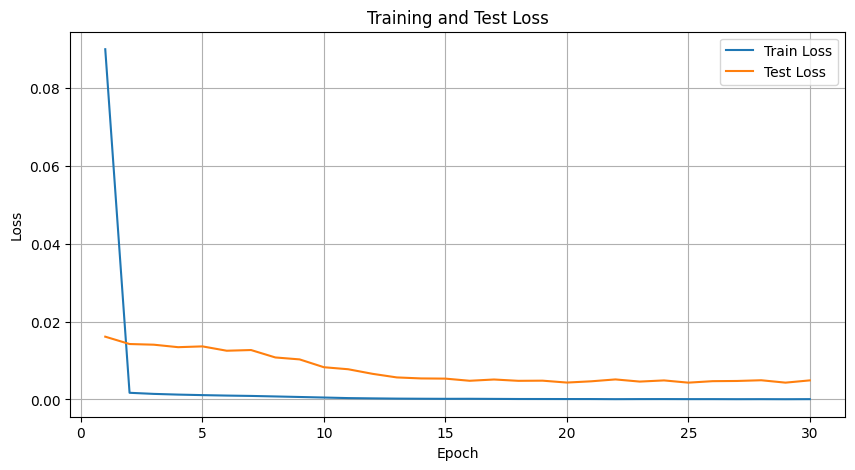

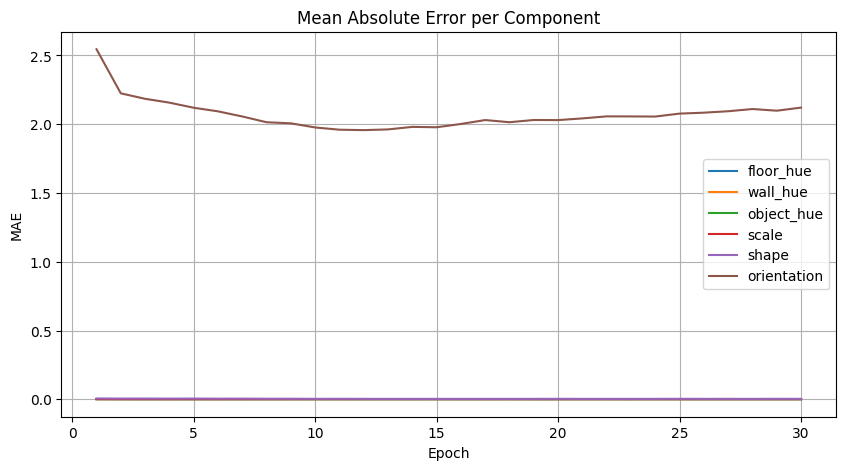

In [17]:
plot_metrics(training_metrics)

In [18]:
utils.save_metrics_to_csv(training_metrics, soda_encoder.name + '.csv')

In [19]:
pretrained_resnet18 = PretrainedResNet18Encoder(out_features=6)
pretrained_training_metrics = train_model(pretrained_resnet18, train_loader, test_loader, EPOCHS, LEARNING_RATE)

/home/cristobal/test/proyecto-taia/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cristobal/test/proyecto-taia/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting Epoch 1/30


/tmp/ipykernel_54786/1721982960.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_latent: torch.Tensor = torch.tensor(max_latent).clone().detach().to(DEVICE)
/tmp/ipykernel_54786/1721982960.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_latent: torch.Tensor = torch.tensor(min_latent).clone().detach().to(DEVICE)


Training - Epoch [1/30], Batch [10/38], Loss: 0.0046
Training - Epoch [1/30], Batch [20/38], Loss: 0.0019
Training - Epoch [1/30], Batch [30/38], Loss: 0.0015
Training - Epoch [1/30], Batch [38/38], Loss: 0.0014
Testing - Epoch [1/30], Batch [10/38], Loss: 0.0134
Testing - Epoch [1/30], Batch [20/38], Loss: 0.0127
Testing - Epoch [1/30], Batch [30/38], Loss: 0.0131
Testing - Epoch [1/30], Batch [38/38], Loss: 0.0133
Epoch [1/30] completed. Train Loss: 0.0483, Time: 5.64s

Starting Epoch 2/30
Training - Epoch [2/30], Batch [10/38], Loss: 0.0012
Training - Epoch [2/30], Batch [20/38], Loss: 0.0009
Training - Epoch [2/30], Batch [30/38], Loss: 0.0007
Training - Epoch [2/30], Batch [38/38], Loss: 0.0006
Testing - Epoch [2/30], Batch [10/38], Loss: 0.0097
Testing - Epoch [2/30], Batch [20/38], Loss: 0.0100
Testing - Epoch [2/30], Batch [30/38], Loss: 0.0117
Testing - Epoch [2/30], Batch [38/38], Loss: 0.0115
Epoch [2/30] completed. Train Loss: 0.0009, Time: 5.64s

Starting Epoch 3/30
Traini

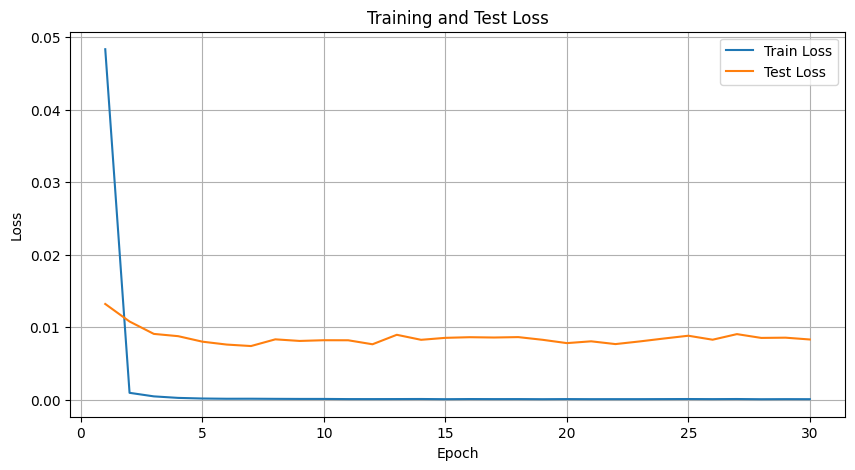

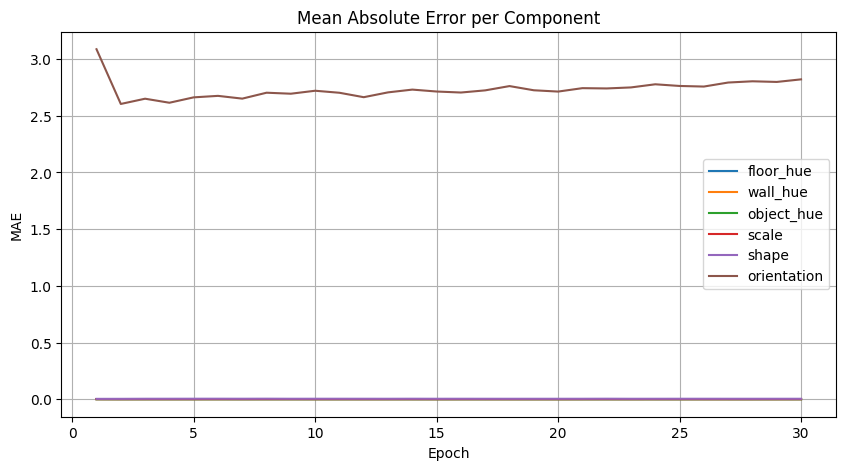

In [20]:
plot_metrics(pretrained_training_metrics)

In [21]:
utils.save_metrics_to_csv(pretrained_training_metrics, pretrained_resnet18.name + '.csv')

In [22]:
def predict(model, image, min_latent, max_latent):
    """
    Realiza una predicción sobre una imagen y desnormaliza el resultado.

    Args:
        model: El modelo entrenado.
        image: La imagen de entrada (tensor).
        latent_mean (torch.Tensor): La media de los latents.
        latent_std (torch.Tensor): La desviación estándar de los latents.

    Returns:
        torch.Tensor: El vector latente predicho y desnormalizado.
    """
    model.eval()
    min_latent = torch.tensor(min_latent).clone().detach().to(DEVICE)
    max_latent = torch.tensor(max_latent).clone().detach().to(DEVICE)
    with torch.no_grad():
        image = torch.tensor(image).to(DEVICE).float()
        image = image.permute(2, 0, 1).unsqueeze(0)
        latent = model(image)
        latent = denormalize_latents(latent, min_latent, max_latent)
    return latent

In [23]:
models: list[nn.Module] = [soda_encoder, pretrained_resnet18]

min_latent, max_latent = get_min_max_latents()
for current_model in models:
    current_model.to(DEVICE)
    current_model.eval()
    index: int = 32
    instance = test_dataset[index]
    image = instance[0]
    expected_latent = instance[1]
    predicted_latent = predict(current_model, image, min_latent, max_latent).squeeze().cpu()

    mae = torch.abs(torch.Tensor(expected_latent) - torch.Tensor(predicted_latent))
    mape = mae / (max_latent - min_latent)  * 100

    for i, factor_name in enumerate(FACTORS_IN_ORDER):
        absolute_error: float = mae[i]
        percent_error: float = mape[i]
        print(f"{factor_name}: {expected_latent[i]:.2f} -> {predicted_latent[i]:.2f} (Error: {absolute_error:.2f}) ({percent_error:.2f}%)")
    print()

floor_hue: 0.00 -> 0.05 (Error: 0.05) (5.26%)
wall_hue: 0.00 -> 0.01 (Error: 0.01) (0.52%)
object_hue: 0.30 -> 0.12 (Error: 0.18) (17.89%)
scale: 0.89 -> 0.79 (Error: 0.10) (10.40%)
shape: 3.00 -> 3.25 (Error: 0.25) (8.34%)
orientation: -8.57 -> -459.49 (Error: 450.92) (751.54%)

floor_hue: 0.00 -> -0.01 (Error: 0.01) (1.00%)
wall_hue: 0.00 -> 0.07 (Error: 0.07) (6.60%)
object_hue: 0.30 -> 0.35 (Error: 0.05) (4.55%)
scale: 0.89 -> 1.41 (Error: 0.52) (52.18%)
shape: 3.00 -> 4.22 (Error: 1.22) (40.66%)
orientation: -8.57 -> -823.20 (Error: 814.63) (1357.71%)



/tmp/ipykernel_54786/3941405032.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_latent = torch.tensor(min_latent).clone().detach().to(DEVICE)
/tmp/ipykernel_54786/3941405032.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_latent = torch.tensor(max_latent).clone().detach().to(DEVICE)
